In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")


In [3]:
df = pd.read_csv("upload/index_1.csv")
df.head(5)

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


In [4]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assume df is already loaded with columns ['date', 'datetime', 'cash_type', 'card', 'money', 'coffee_name']

# Step 1: Parse the datetime if not already
if not np.issubdtype(df['datetime'].dtype, np.datetime64):
    df['datetime'] = pd.to_datetime(df['datetime'])

# Step 2: Group by month and coffee sales (assuming 'money' is sales amount or 'card' + 'cash_type' columns)
# Here, we assume 'money' tracks monetary sales. If 'coffee_name' is per cup, group accordingly.
monthly_sales = df.groupby(pd.Grouper(key='datetime', freq='M'))['money'].sum()

# Step 3: Use the last year (12 months) as training data
last_12_months = monthly_sales.last('12M')

# Step 4: Fit SARIMA (seasonal ARIMA model)
# (order and seasonal_order can be tuned)
model = SARIMAX(last_12_months, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)

# Step 5: Forecast sales for next month
forecast = model_fit.forecast(steps=1)
print("Predicted coffee sales for next month:", forecast.iloc[0])


Predicted coffee sales for next month: 13346.72168013916


In [7]:
df.value_counts("date")

date
2024-10-11    26
2025-02-03    25
2024-07-30    24
2025-02-05    24
2024-09-22    24
              ..
2024-08-27     1
2024-05-08     1
2024-07-15     1
2024-04-27     1
2024-11-24     1
Length: 381, dtype: int64

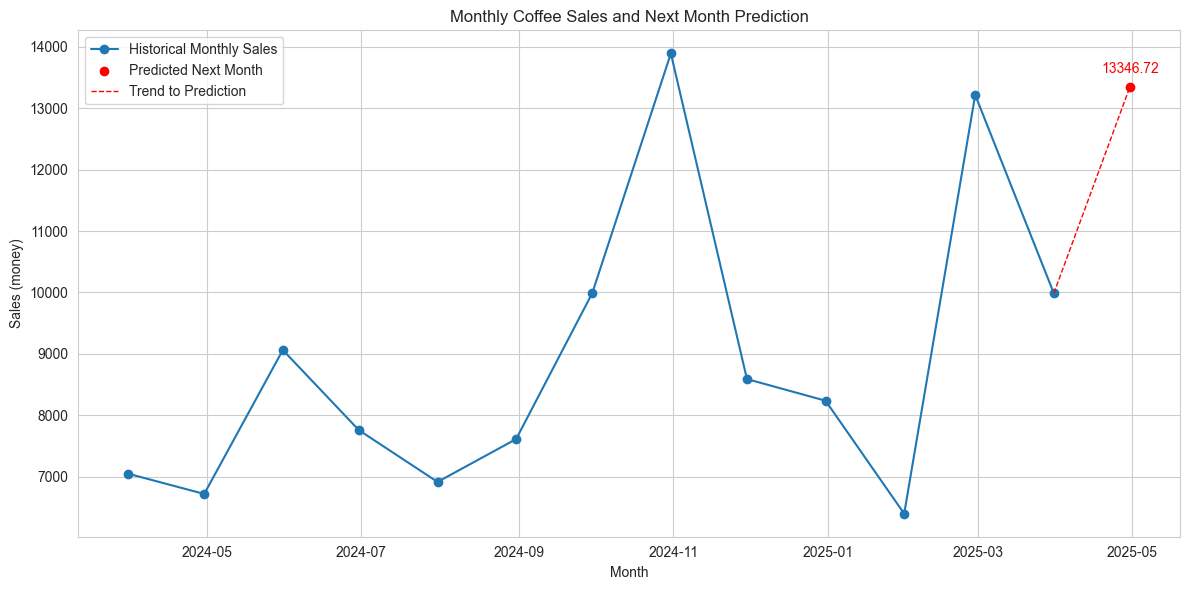

In [6]:
import matplotlib.pyplot as plt

# Plot historical monthly sales
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', label='Historical Monthly Sales')

# Plot the predicted next month's sales
# Compute the timestamp for the prediction
next_month = monthly_sales.index[-1] + pd.offsets.MonthEnd(1)
plt.scatter(next_month, forecast.iloc[0], color='red', label='Predicted Next Month', zorder=5)
plt.plot([monthly_sales.index[-1], next_month], [monthly_sales.iloc[-1], forecast.iloc[0]], 
         'r--', lw=1, label='Trend to Prediction')

# Annotate the prediction
plt.annotate(f"{forecast.iloc[0]:.2f}", (next_month, forecast.iloc[0]), 
             textcoords="offset points", xytext=(0,10), ha='center', color='red', fontsize=10)

plt.title("Monthly Coffee Sales and Next Month Prediction")
plt.xlabel("Month")
plt.ylabel("Sales (money)")
plt.legend()
plt.tight_layout()
plt.show()


Predicted most sold coffee for next month: Americano
Predicted sales: 119.50000874999563


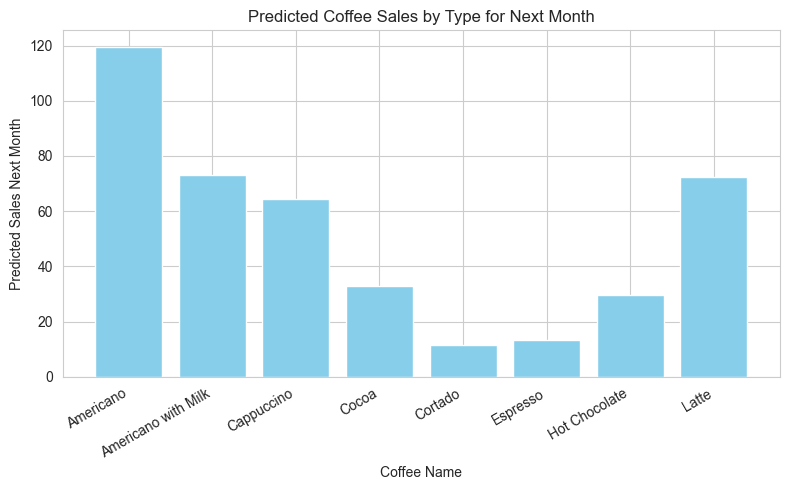

In [9]:
# Predict the most sold coffee for next month

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare data: group by month and coffee_name, aggregate counts
monthly_coffee_sales = df.groupby([pd.Grouper(key='datetime', freq='M'), 'coffee_name']).size().unstack(fill_value=0)

# Take the last 12 months as training data
last_12_months_coffee = monthly_coffee_sales.tail(12)

# Fit SARIMA for each coffee type and predict next month's sales
predictions = {}
for coffee in last_12_months_coffee.columns:
    series = last_12_months_coffee[coffee]
    # Handle all-zero columns or insufficient data
    # If sum is 0, skip
    if series.sum() == 0 or series.count() < 2:
        predictions[coffee] = 0
        continue
    try:
        model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,12))
        model_fit = model.fit(disp=False)
        pred = model_fit.forecast(steps=1).iloc[0]
        predictions[coffee] = pred if pred > 0 else 0
    except:
        predictions[coffee] = 0  # fallback

# Find the coffee with the highest predicted sales
most_sold_coffee = max(predictions, key=predictions.get)
print("Predicted most sold coffee for next month:", most_sold_coffee)
print("Predicted sales:", predictions[most_sold_coffee])

# (Optional) Show a bar chart of all predictions
plt.figure(figsize=(8, 5))
plt.bar(predictions.keys(), predictions.values(), color='skyblue')
plt.xlabel('Coffee Name')
plt.ylabel('Predicted Sales Next Month')
plt.title('Predicted Coffee Sales by Type for Next Month')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()
